In [49]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


from matplotlib import pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from rfpimp import permutation_importances


In [1]:
# NSL-KDD datasets
df = pd.read_csv('NSL-KDD/KDDTrain+.txt', sep=',')
df.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'labels', 'difficulty']

protocols = df.protocol_type.value_counts()
protocols_map = {}
for i, (prop, count) in enumerate(protocols.items()):
    protocols_map[prop] = i
df.protocol_type = df.protocol_type.map(protocols_map)

services = df.service.value_counts()
service_map = {}
for i, (ser, count) in enumerate(services.items()):
    service_map[ser] = i
df.service = df.service.map(service_map)

flag_map = {}
flags = df.flag.value_counts()
for i, (flag, count) in enumerate(flags.items()):
    flag_map[flag] = i
df.flag = df.flag.map(flag_map)

df['targets'] = df.labels.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})

df['targets'] = df.targets.astype(int)

In [51]:
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels,difficulty,targets
0,0,1,6,0,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,0,1,1,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,0,0,0,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,0,0,0,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,0,1,2,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


In [52]:
X = df.drop(['labels', 'difficulty', 'targets'], axis=1)
y = df['targets']

In [53]:
X.shape, y.shape

((125972, 41), (125972,))

# Recursive Feature Elimination

In [20]:
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(clf, n_features_to_select=1)
rfe.fit(X,y)
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), new_cols_name)))

[(5, 'same_srv_rate'), (7, 'dst_host_serror_rate'), (14, 'serror_rate'), (19, 'dst_host_srv_serror_rate')]


# permutation_importances using rfpimp

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [20]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(clf, X_train, y_train, r2)
perm_imp_rfpimp

,Importance
Feature,
src_bytes,0.116844
dst_host_same_src_port_rate,0.082208
dst_bytes,0.070106
hot,0.060926
dst_host_same_srv_rate,0.013771
dst_host_srv_diff_host_rate,0.012936
dst_host_rerror_rate,0.012102
service,0.009181
dst_host_srv_count,0.007511


In [23]:
dtc = DecisionTreeClassifier(random_state=0)
perm_imp_rfpimp = permutation_importances(dtc, X_train, y_train, r2)
perm_imp_rfpimp

,Importance
Feature,
dst_host_same_srv_rate,1.114862
src_bytes,0.994643
dst_host_same_src_port_rate,0.670797
dst_host_srv_count,0.431534
service,0.303484
dst_host_rerror_rate,0.283121
count,0.169951
logged_in,0.158986
hot,0.145672


# Linear Regression Feature Importance

Feature: 0, Score: 0.00000
Feature: 1, Score: 0.36360
Feature: 2, Score: -0.00252
Feature: 3, Score: 0.04716
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: -1.15115
Feature: 7, Score: 0.21326
Feature: 8, Score: 0.18815
Feature: 9, Score: 0.05584
Feature: 10, Score: 0.47565
Feature: 11, Score: 0.34591
Feature: 12, Score: 0.00647
Feature: 13, Score: 0.82212
Feature: 14, Score: -0.62264
Feature: 15, Score: -0.00648
Feature: 16, Score: -0.02711
Feature: 17, Score: 0.19444
Feature: 18, Score: 0.04463
Feature: 19, Score: 0.00000
Feature: 20, Score: -0.67615
Feature: 21, Score: -0.38018
Feature: 22, Score: 0.00040
Feature: 23, Score: -0.00012
Feature: 24, Score: -0.19217
Feature: 25, Score: 0.40463
Feature: 26, Score: 0.12104
Feature: 27, Score: 0.42167
Feature: 28, Score: -0.34644
Feature: 29, Score: 0.06873
Feature: 30, Score: 0.12016
Feature: 31, Score: 0.00078
Feature: 32, Score: -0.00187
Feature: 33, Score: 0.37658
Feature: 34, Score: 0.60584
Feature: 35, Score:

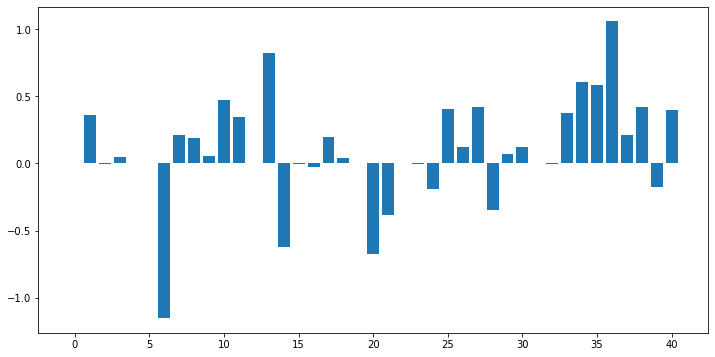

In [34]:
model = LinearRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

#display features
plt.figure(figsize=(12,6))
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Logistic Regression Feature Importance

/home/ramesh/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: 0.00010
Feature: 1, Score: 0.00000
Feature: 2, Score: -0.00000
Feature: 3, Score: -0.00000
Feature: 4, Score: 0.00025
Feature: 5, Score: 0.00054
Feature: 6, Score: 0.00000
Feature: 7, Score: -0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: -0.00002
Feature: 23, Score: 0.00003
Feature: 24, Score: -0.00000
Feature: 25, Score: -0.00000
Feature: 26, Score: -0.00000
Feature: 27, Score: -0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00014
Feature: 32, Score: 0.00025
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.

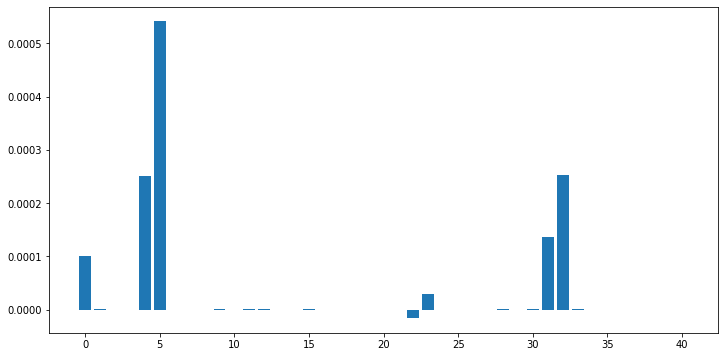

In [36]:
# define the model
model = LogisticRegression()
# fit the model
model.fit(X, y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Decision Tree Feature Importance

Feature: 0, Score: 0.00574
Feature: 1, Score: 0.00327
Feature: 2, Score: 0.06728
Feature: 3, Score: 0.00057
Feature: 4, Score: 0.56718
Feature: 5, Score: 0.02380
Feature: 6, Score: 0.00064
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00018
Feature: 9, Score: 0.03151
Feature: 10, Score: 0.00026
Feature: 11, Score: 0.00194
Feature: 12, Score: 0.00253
Feature: 13, Score: 0.00012
Feature: 14, Score: 0.00030
Feature: 15, Score: 0.00028
Feature: 16, Score: 0.00206
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00004
Feature: 22, Score: 0.04432
Feature: 23, Score: 0.00060
Feature: 24, Score: 0.00040
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00090
Feature: 27, Score: 0.00004
Feature: 28, Score: 0.00026
Feature: 29, Score: 0.00122
Feature: 30, Score: 0.00019
Feature: 31, Score: 0.00268
Feature: 32, Score: 0.02680
Feature: 33, Score: 0.00577
Feature: 34, Score: 0.05207
Feature: 35, Score: 0.11504
Fe

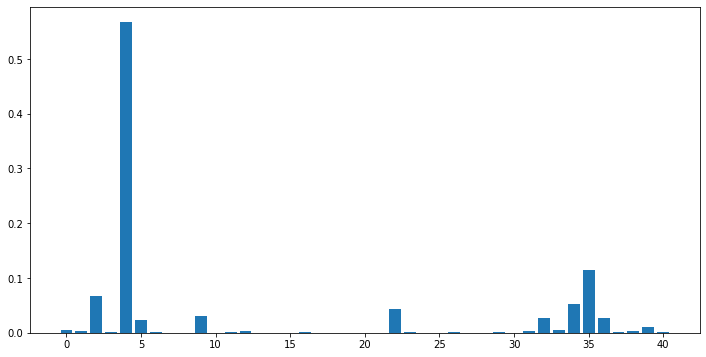

In [38]:
model = DecisionTreeRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00478
Feature: 1, Score: 0.04796
Feature: 2, Score: 0.01427
Feature: 3, Score: 0.00115
Feature: 4, Score: 0.55545
Feature: 5, Score: 0.00487
Feature: 6, Score: 0.00045
Feature: 7, Score: 0.00075
Feature: 8, Score: 0.00003
Feature: 9, Score: 0.00469
Feature: 10, Score: 0.00111
Feature: 11, Score: 0.00200
Feature: 12, Score: 0.01662
Feature: 13, Score: 0.00010
Feature: 14, Score: 0.00003
Feature: 15, Score: 0.00014
Feature: 16, Score: 0.00014
Feature: 17, Score: 0.00004
Feature: 18, Score: 0.00012
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.16037
Feature: 23, Score: 0.00031
Feature: 24, Score: 0.00014
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00114
Feature: 27, Score: 0.00003
Feature: 28, Score: 0.00014
Feature: 29, Score: 0.00906
Feature: 30, Score: 0.00001
Feature: 31, Score: 0.00136
Feature: 32, Score: 0.02746
Feature: 33, Score: 0.00659
Feature: 34, Score: 0.07478
Feature: 35, Score: 0.04912
Fe

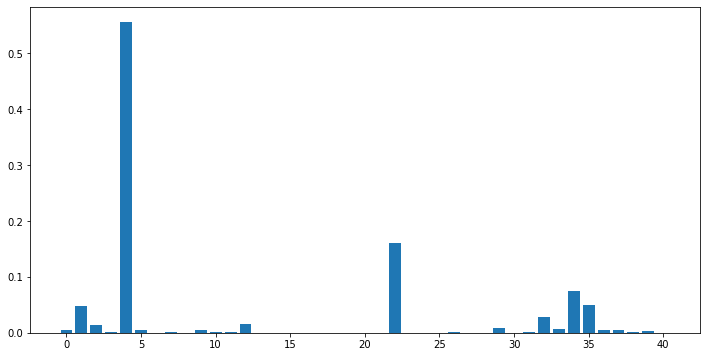

In [40]:
# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Random Forest Feature Importance

Feature: 0, Score: 0.00530
Feature: 1, Score: 0.00263
Feature: 2, Score: 0.06691
Feature: 3, Score: 0.00054
Feature: 4, Score: 0.56483
Feature: 5, Score: 0.03337
Feature: 6, Score: 0.00065
Feature: 7, Score: 0.00034
Feature: 8, Score: 0.00027
Feature: 9, Score: 0.01917
Feature: 10, Score: 0.00027
Feature: 11, Score: 0.00347
Feature: 12, Score: 0.00573
Feature: 13, Score: 0.00098
Feature: 14, Score: 0.00005
Feature: 15, Score: 0.00037
Feature: 16, Score: 0.00204
Feature: 17, Score: 0.00017
Feature: 18, Score: 0.00028
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00015
Feature: 22, Score: 0.03468
Feature: 23, Score: 0.00063
Feature: 24, Score: 0.00021
Feature: 25, Score: 0.00019
Feature: 26, Score: 0.00083
Feature: 27, Score: 0.00008
Feature: 28, Score: 0.00038
Feature: 29, Score: 0.00107
Feature: 30, Score: 0.00013
Feature: 31, Score: 0.00245
Feature: 32, Score: 0.02382
Feature: 33, Score: 0.01774
Feature: 34, Score: 0.05015
Feature: 35, Score: 0.11688
Fe

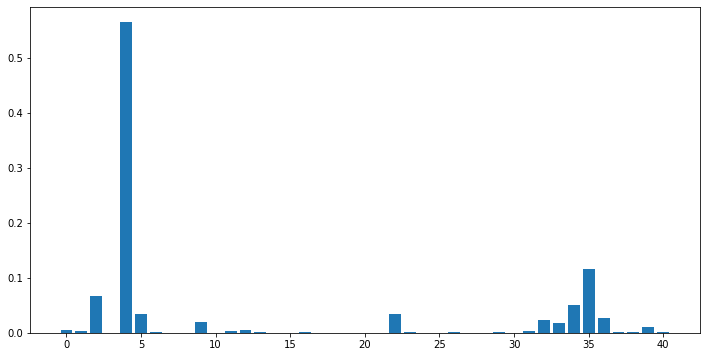

In [42]:
# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Feature: 0, Score: 0.00376
Feature: 1, Score: 0.02697
Feature: 2, Score: 0.03281
Feature: 3, Score: 0.06197
Feature: 4, Score: 0.16151
Feature: 5, Score: 0.07609
Feature: 6, Score: 0.00006
Feature: 7, Score: 0.00862
Feature: 8, Score: 0.00002
Feature: 9, Score: 0.00695
Feature: 10, Score: 0.00031
Feature: 11, Score: 0.01344
Feature: 12, Score: 0.00629
Feature: 13, Score: 0.00014
Feature: 14, Score: 0.00003
Feature: 15, Score: 0.00022
Feature: 16, Score: 0.00014
Feature: 17, Score: 0.00004
Feature: 18, Score: 0.00006
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00099
Feature: 22, Score: 0.04937
Feature: 23, Score: 0.02094
Feature: 24, Score: 0.02557
Feature: 25, Score: 0.01986
Feature: 26, Score: 0.00704
Feature: 27, Score: 0.00315
Feature: 28, Score: 0.09752
Feature: 29, Score: 0.08148
Feature: 30, Score: 0.00533
Feature: 31, Score: 0.01846
Feature: 32, Score: 0.03041
Feature: 33, Score: 0.03079
Feature: 34, Score: 0.04655
Feature: 35, Score: 0.04460
Fe

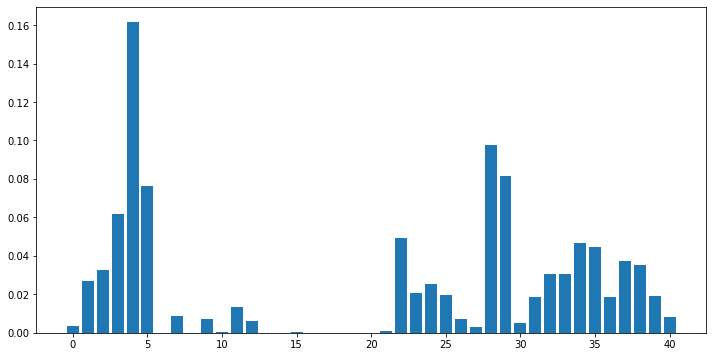

In [43]:
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# XGBoost Classification Feature Importance

Feature: 0, Score: 0.00184
Feature: 1, Score: 0.01378
Feature: 2, Score: 0.00873
Feature: 3, Score: 0.00270
Feature: 4, Score: 0.04664
Feature: 5, Score: 0.00933
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.01230
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00821
Feature: 10, Score: 0.00217
Feature: 11, Score: 0.00791
Feature: 12, Score: 0.01188
Feature: 13, Score: 0.00033
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00011
Feature: 16, Score: 0.00023
Feature: 17, Score: 0.00039
Feature: 18, Score: 0.00025
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00069
Feature: 22, Score: 0.02826
Feature: 23, Score: 0.01151
Feature: 24, Score: 0.00681
Feature: 25, Score: 0.01142
Feature: 26, Score: 0.00017
Feature: 27, Score: 0.00064
Feature: 28, Score: 0.71159
Feature: 29, Score: 0.02364
Feature: 30, Score: 0.00014
Feature: 31, Score: 0.00036
Feature: 32, Score: 0.00359
Feature: 33, Score: 0.00492
Feature: 34, Score: 0.01864
Feature: 35, Score: 0.01270
Fe

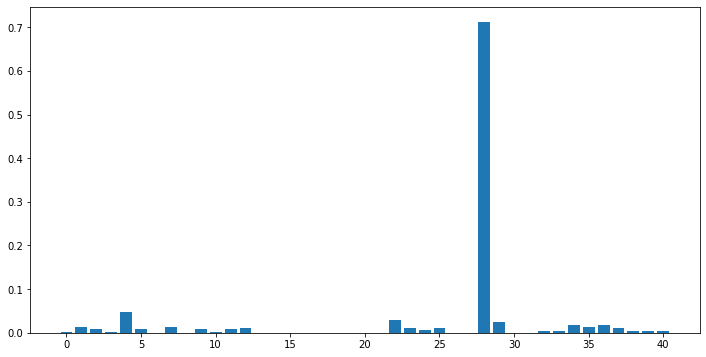

In [45]:
# define the model
model = XGBClassifier()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Permutation Feature Importance

# permutation_importance from sklearn

Feature: 0, Score: 0.00018
Feature: 1, Score: 0.03164
Feature: 2, Score: 0.00171
Feature: 3, Score: 0.00003
Feature: 4, Score: 0.04561
Feature: 5, Score: 0.00349
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00017
Feature: 8, Score: 0.00002
Feature: 9, Score: 0.00152
Feature: 10, Score: 0.00002
Feature: 11, Score: 0.00199
Feature: 12, Score: 0.00006
Feature: 13, Score: 0.00005
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00002
Feature: 16, Score: 0.00005
Feature: 17, Score: 0.00001
Feature: 18, Score: 0.00001
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00003
Feature: 22, Score: 0.00038
Feature: 23, Score: 0.00012
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00002
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00002
Feature: 29, Score: 0.00041
Feature: 30, Score: 0.00002
Feature: 31, Score: 0.00032
Feature: 32, Score: 0.00055
Feature: 33, Score: 0.00082
Feature: 34, Score: 0.00052
Feature: 35, Score: 0.00401
Fe

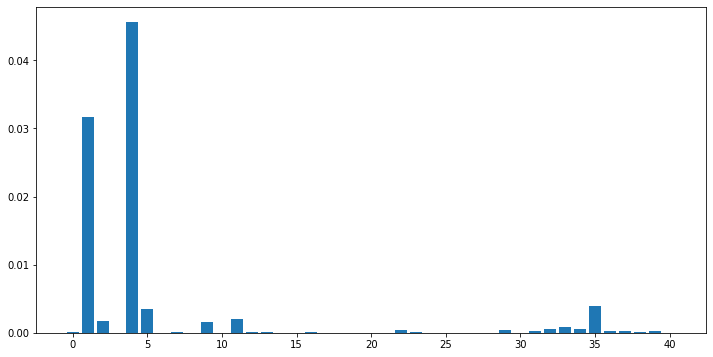

In [47]:
# define the model
model = RandomForestClassifier()
# fit the model
model.fit(X, y)
# perform permutation importance
results = permutation_importance(model, X, y, scoring='accuracy')
# get importance
importance = results.importances_mean
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.figure(figsize=(12,6))
plt.bar([x for x in range(len(importance))], importance)
plt.show()